<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

# Writing a Transpiler Pass

## Introduction

A central component of Qiskit Terra is the transpiler, which is designed for modularity and extensibility. The goal is to be able to easily write new circuit transformations (known as transpiler *passes*), and combine them with other existing passes. In this way, the transpiler opens up the door for research into aggressive optimization of quantum circuits.

In this notebook, we show how to develop a simple transpiler pass. To do so, we first introduce the internal representation of quantum circuits in Qiskit, in the form of a Directed Acyclic Graph, or **DAG**. Then, we illustrate a simple swap mapper pass, which transforms an input circuit to be compatible with a limited-connectivity quantum device.

## Introducing the DAG

In Qiskit, we represent circuits internally using a Directed Acyclic Graph (DAG). The advantage of this representation over a pure list of gates (i.e., *netlist*) is that the flow of information between operations are explicit, making it easier for passes to make transformation decisions without changing the semantics of the circuit.

Let's start by building a simple circuit, and examining its DAG.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
circ = QuantumCircuit(q, c)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.measure(q[0], c[0])
circ.rz(0.5, q[1]).c_if(c, 2)
circ.draw()

In the DAG, there are three kinds of graph nodes: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red). Each edge indicates data flow (or dependency) between two nodes. 

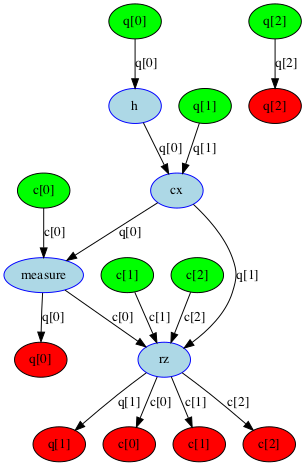

In [2]:
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
dag = circuit_to_dag(circ)
dag_drawer(dag)

Therefore, writing a transpiler pass means using Qiskit's DAGCircuit API to analyze or transform the circuit. Let's see some examples of this.

**a. Get all op nodes in the DAG:**

In [3]:
dag.op_nodes()

Each node is an instance of the ``DAGNode`` class. Let's examine the information stored in the second op node.

In [4]:
node = dag.op_nodes()[3]
print("node name: ", node.name)
print("node op: ", node.op)
print("node qargs: ", node.qargs)
print("node cargs: ", node.cargs)
print("node condition: ", node.condition)

node name:  rz
node op:  <qiskit.extensions.standard.rz.RZGate object at 0x1a19b67748>
node qargs:  [Qubit(QuantumRegister(3, 'q'), 1)]
node cargs:  []
node condition:  (ClassicalRegister(3, 'c'), 2)


**b. Add an operation to the back:**

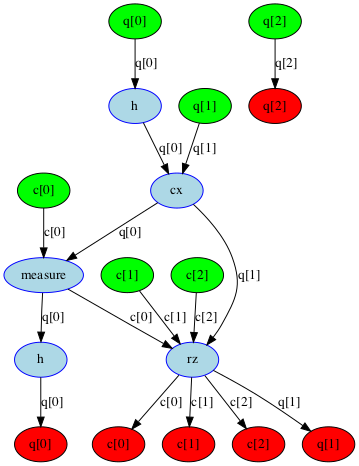

In [5]:
from qiskit.extensions.standard import HGate
dag.apply_operation_back(HGate(), qargs=[q[0]])
dag_drawer(dag)

**c. Add an operation to the front:**

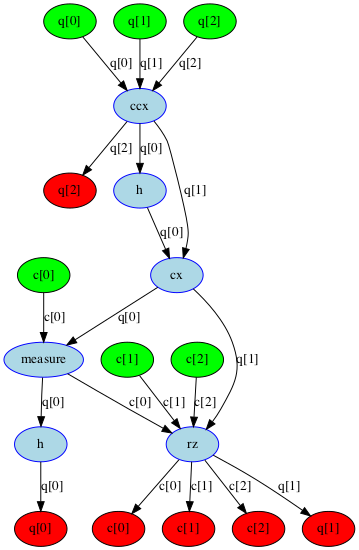

In [6]:
from qiskit.extensions.standard import ToffoliGate
dag.apply_operation_front(ToffoliGate(), qargs=[q[0], q[1], q[2]], cargs=[])
dag_drawer(dag)

**d. Substitute a node with a subcircuit:**

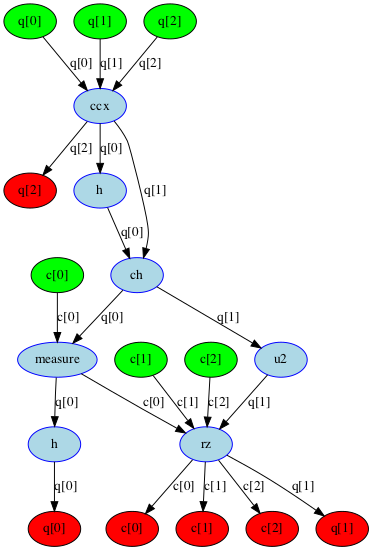

In [7]:
from qiskit.extensions.standard import CHGate, U2Gate, CnotGate
mini_dag = DAGCircuit()
p = QuantumRegister(2, "p")
mini_dag.add_qreg(p)
mini_dag.apply_operation_back(CHGate(), qargs=[p[1], p[0]])
mini_dag.apply_operation_back(U2Gate(0.1, 0.2), qargs=[p[1]])

# substitute the cx node with the above mini-dag
cx_node = dag.op_nodes(op=CnotGate).pop()
dag.substitute_node_with_dag(node=cx_node, input_dag=mini_dag, wires=[p[0], p[1]])
dag_drawer(dag)

Finally, after all transformations are complete, we can convert back to a regular QuantumCircuit object.
This is what the transpiler does! It takes a circuit, operates on it in DAG form, and outputs a transformed circuit.

In [8]:
from qiskit.converters import dag_to_circuit
circuit = dag_to_circuit(dag)
circuit.draw()

## Implementing a BasicMapper Pass

Now that we are familiar with the DAG, let's use it to write a transpiler pass. Here we will implement a basic pass for mapping an arbitrary circuit to a device with limited qubit connectivity. We call this the BasicMapper. This pass is included in Qiskit Terra as well.

The first thing to do when writing a transpiler pass is to decide whether the pass class derives from a ``TransformationPass`` or ``AnalysisPass``. Transformation passes modify the circuit, while analysis passes only collect information about a circuit (to be used by other passes). Then, the ``run(dag)`` method is implemented, which does the main task. Finally, the pass is registered inside the ``qiskit.transpiler.passes`` module.

This pass functions as follows: it traverses the DAG layer-by-layer (each layer is a group of operations that does not act on independent qubits, so in theory all operations in a layer can be done independently). For each operation, if it does not already meet the coupling map constraints, the pass identifies a swap path and inserts swaps to bring the two qubits close to each other.

Follow the comments in the code for more details.

In [9]:
from copy import copy

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout
from qiskit.extensions.standard import SwapGate


class BasicSwap(TransformationPass):
    """
    Maps (with minimum effort) a DAGCircuit onto a `coupling_map` adding swap gates.
    """

    def __init__(self,
                 coupling_map,
                 initial_layout=None):
        """
        Maps a DAGCircuit onto a `coupling_map` using swap gates.
        Args:
            coupling_map (CouplingMap): Directed graph represented a coupling map.
            initial_layout (Layout): initial layout of qubits in mapping
        """
        super().__init__()
        self.coupling_map = coupling_map
        self.initial_layout = initial_layout

    def run(self, dag):
        """
        Runs the BasicSwap pass on `dag`.
        Args:
            dag (DAGCircuit): DAG to map.

        Returns:
            DAGCircuit: A mapped DAG.

        Raises:
            TranspilerError: if the coupling map or the layout are not
            compatible with the DAG
        """
        new_dag = DAGCircuit()

        if self.initial_layout is None:
            if self.property_set["layout"]:
                self.initial_layout = self.property_set["layout"]
            else:
                self.initial_layout = Layout.generate_trivial_layout(*dag.qregs.values())

        if len(dag.qubits()) != len(self.initial_layout):
            raise TranspilerError('The layout does not match the amount of qubits in the DAG')

        if len(self.coupling_map.physical_qubits) != len(self.initial_layout):
            raise TranspilerError(
                "Mappers require to have the layout to be the same size as the coupling map")

        current_layout = self.initial_layout.copy()

        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.twoQ_gates():
                physical_q0 = current_layout[gate.qargs[0]]
                physical_q1 = current_layout[gate.qargs[1]]
                if self.coupling_map.distance(physical_q0, physical_q1) != 1:
                    # Insert a new layer with the SWAP(s).
                    swap_layer = DAGCircuit()

                    path = self.coupling_map.shortest_undirected_path(physical_q0, physical_q1)
                    for swap in range(len(path) - 2):
                        connected_wire_1 = path[swap]
                        connected_wire_2 = path[swap + 1]

                        qubit_1 = current_layout[connected_wire_1]
                        qubit_2 = current_layout[connected_wire_2]

                        # create qregs
                        for qreg in current_layout.get_registers():
                            if qreg not in swap_layer.qregs.values():
                                swap_layer.add_qreg(qreg)

                        # create the swap operation
                        swap_layer.apply_operation_back(SwapGate(),
                                                        qargs=[qubit_1, qubit_2],
                                                        cargs=[])

                    # layer insertion
                    edge_map = current_layout.combine_into_edge_map(self.initial_layout)
                    new_dag.compose_back(swap_layer, edge_map)

                    # update current_layout
                    for swap in range(len(path) - 2):
                        current_layout.swap(path[swap], path[swap + 1])

            edge_map = current_layout.combine_into_edge_map(self.initial_layout)
            new_dag.extend_back(subdag, edge_map)

        return new_dag

Let's test this pass on a small example circuit.

In [10]:
q = QuantumRegister(7, 'q')
in_circ = QuantumCircuit(q)
in_circ.h(q[0])
in_circ.cx(q[0], q[4])
in_circ.cx(q[2], q[3])
in_circ.cx(q[6], q[1])
in_circ.cx(q[5], q[0])
in_circ.rz(0.1, q[2])
in_circ.cx(q[5], q[0])

Now we construct a pass manager that contains our new pass. We pass the example circuit above to this pass manager, and obtain a new, transformed circuit.

In [11]:
from qiskit.transpiler import PassManager
from qiskit.transpiler import CouplingMap
from qiskit import BasicAer
pm = PassManager()
coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]
coupling_map = CouplingMap(couplinglist=coupling)

pm.append([BasicSwap(coupling_map)])

out_circ = pm.run(in_circ)

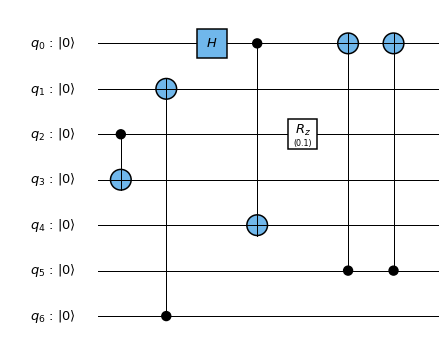

In [12]:
in_circ.draw(output='mpl')

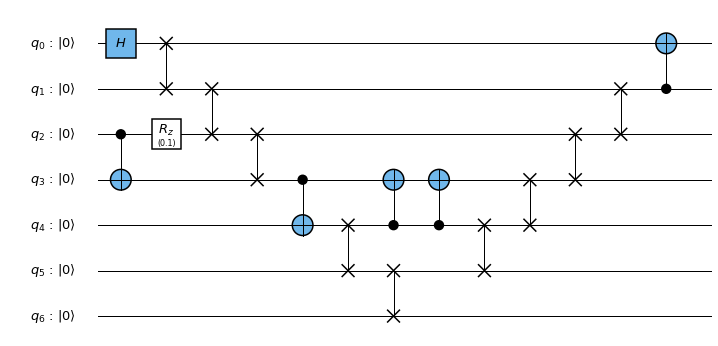

In [13]:
out_circ.draw(output='mpl')

Note that this pass only inserts the swaps necessary to make every two-qubit interaction conform to the device coupling map. It does not, for example, care about the direction of interactions, or the native gate set supported by the device. This is a design philosophy of Qiskit's transpiler: every pass performs a small, well-defined action, and the aggressive circuit optimization is achieved by the pass manager through combining multiple passes.